# Testis Replicate 1 1k UMI Cutoff

In [1]:
options(repr.plot.width=10, repr.plot.height=10)

In [1]:
DATA <- '../output/testis_cell_selection/2018-03-29_1k_umi_dump_data_testis1_raw_counts.tsv'
OUTDIR <- '../output/testis1_scRNAseq_umi1k'
dir.create(OUTDIR, showWarnings=FALSE)

REFERENCES_DIR <- Sys.getenv('REFERENCES_DIR')
NAME <- 'Testis1'

# Get list of mitochondiral genes
fbgn2chrom <- read.table('../output/fbgn2chrom.tsv', header=T)
fbgn2symbol <- read.csv(file.path(REFERENCES_DIR, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'), header=T, sep = '\t')[, c('gene_symbol', 'primary_FBgn')]
mito <- fbgn2chrom[fbgn2chrom$chrom == 'chrM', 'FBgn']

In [2]:
source('../lib/seurat.R')

In [3]:
library(Seurat)
library(dplyr)
library(Matrix)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
dat <- read.table(DATA, header=TRUE, row.names='FBgn')

In [5]:
head(dat)

,AAACCTGAGACAAGCC,AAACCTGAGCTTATCG,AAACCTGAGGAGCGTT,AAACCTGCAATGGACG,AAACCTGCAGTGACAG,AAACCTGCATGAAGTA,AAACCTGGTCTTCAAG,AAACCTGGTGTAATGA,AAACCTGGTTCATGGT,AAACCTGTCAGGCAAG,⋯,TTTGGTTTCGTTGACA,TTTGTCAAGAAACGCC,TTTGTCAAGAGGACGG,TTTGTCAAGAGTAAGG,TTTGTCAAGCAAATCA,TTTGTCAAGCGTCAAG,TTTGTCAAGCTGAACG,TTTGTCAAGGCCCGTT,TTTGTCAGTGTTAAGA,TTTGTCATCACAGTAC
FBgn0031081,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FBgn0052826,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FBgn0031085,0,0,0,0,0,0,0,0,2,0,⋯,0,0,0,1,0,0,0,0,0,0
FBgn0062565,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FBgn0031088,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FBgn0041626,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [6]:
paste('The minimum number of expressed genes in this dataset is:', min(colSums(dat > 0)))

[1] "The minimum number of expressed genes in this dataset is: 3"

In [7]:
# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). 
sobj <- CreateSeuratObject(raw.data = dat, min.cells = 3, min.genes=200, project = NAME)
nCells <- dim(sobj@meta.data)[1]

# calculate the percent genes on chrom M
mask <- row.names(sobj@raw.data) %in% mito
percent.mito <- Matrix::colSums(sobj@raw.data[mask, ]/Matrix::colSums(sobj@raw.data)) * 100
sobj <- AddMetaData(object = sobj, metadata = percent.mito, col.name = "percent_mito")

In [8]:
nCells

[1] 3513

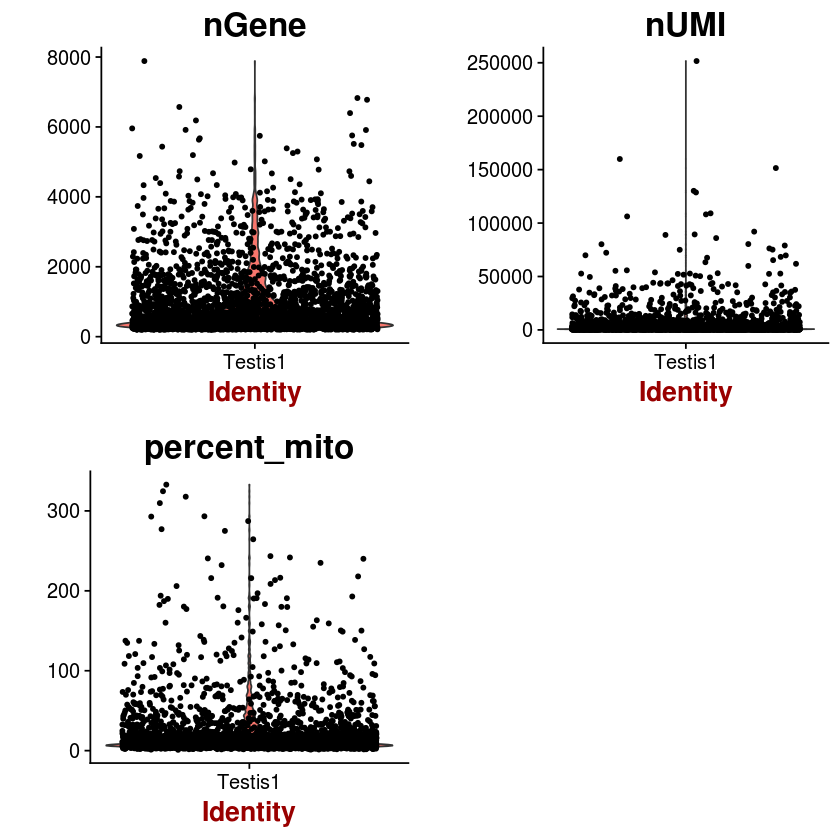

In [9]:
VlnPlot(object = sobj, features.plot = c('nGene', 'nUMI', 'percent_mito'), nCol = 2)

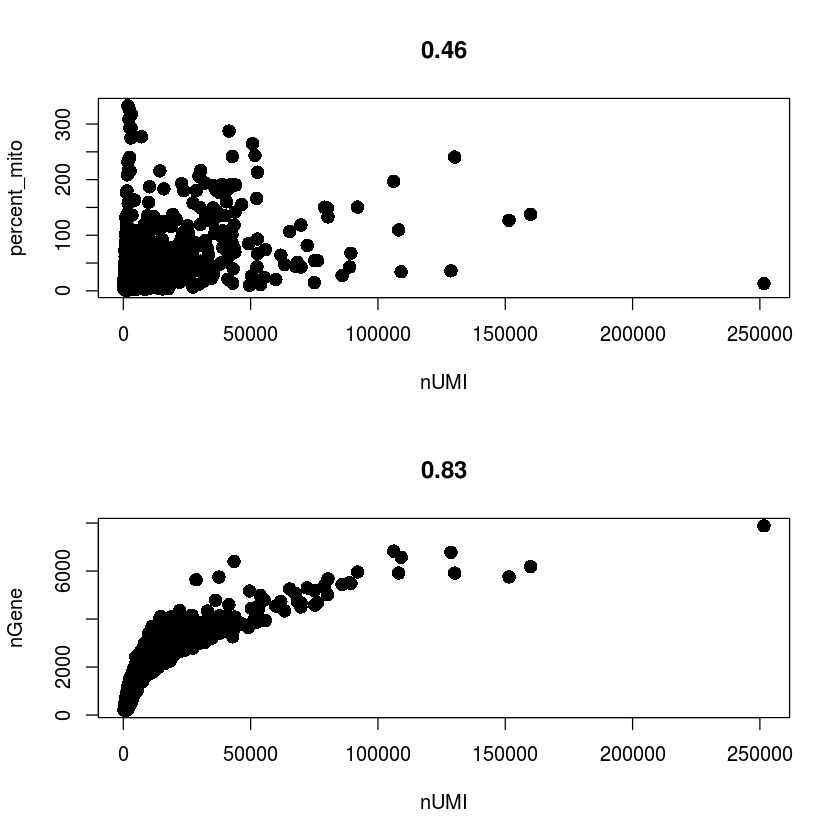

In [10]:
par(mfrow = c(2, 1))
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'percent_mito')
GenePlot(object = sobj, gene1 = 'nUMI', gene2 = 'nGene')

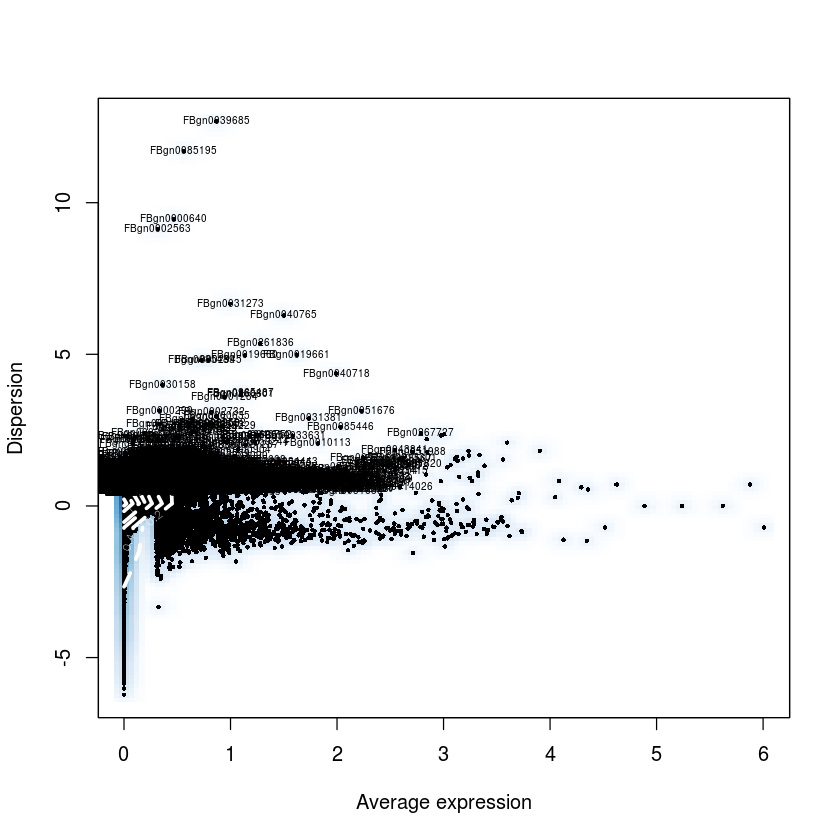

In [11]:
sobj <- NormalizeData(object = sobj, normalization.method = "LogNormalize", scale.factor = 1e4)
sobj <- FindVariableGenes(object = sobj, mean.function = ExpMean, dispersion.function = LogVMR,
                           x.low.cutoff = 0.01, 
                           x.high.cutoff = 2.8, 
                           y.cutoff = 0.5,
                           y.high.cutoff = Inf
                          )

In [12]:
length(x = sobj@var.genes)

[1] 3434

In [13]:
sobj <- ScaleData(object = sobj, vars.to.regress = c("nUMI"), display.progress = F)

In [14]:
### Perform linear dimensional reduction
sobj <- RunPCA(object = sobj, pc.genes = sobj@var.genes, do.print = FALSE, pcs.print = 1:5, genes.print = 5, pcs.compute = 100)

In [15]:
PrintPCA(object = sobj, pcs.print = 1:5, genes.print = 5, use.full = FALSE)

[1] "PC1"
[1] "FBgn0014026" "FBgn0265413" "FBgn0000042" "FBgn0261260" "FBgn0030521"
[1] ""
[1] "FBgn0036415" "FBgn0028567" "FBgn0046297" "FBgn0051988" "FBgn0031751"
[1] ""
[1] ""
[1] "PC2"
[1] "FBgn0265487" "FBgn0019661" "FBgn0010113" "FBgn0001316" "FBgn0019660"
[1] ""
[1] "FBgn0263415" "FBgn0043841" "FBgn0063497" "FBgn0262563" "FBgn0038198"
[1] ""
[1] ""
[1] "PC3"
[1] "FBgn0262104" "FBgn0035608" "FBgn0250904" "FBgn0036809" "FBgn0034837"
[1] ""
[1] "FBgn0002543" "FBgn0283451" "FBgn0019660" "FBgn0013733" "FBgn0002733"
[1] ""
[1] ""
[1] "PC4"
[1] "FBgn0264307" "FBgn0028669" "FBgn0037064" "FBgn0033868" "FBgn0011244"
[1] ""
[1] "FBgn0004795" "FBgn0000015" "FBgn0265487" "FBgn0086408" "FBgn0002592"
[1] ""
[1] ""
[1] "PC5"
[1] "FBgn0000299" "FBgn0030796" "FBgn0030993" "FBgn0268063" "FBgn0016075"
[1] ""
[1] "FBgn0266801" "FBgn0004795" "FBgn0000015" "FBgn0263930" "FBgn0262614"
[1] ""
[1] ""


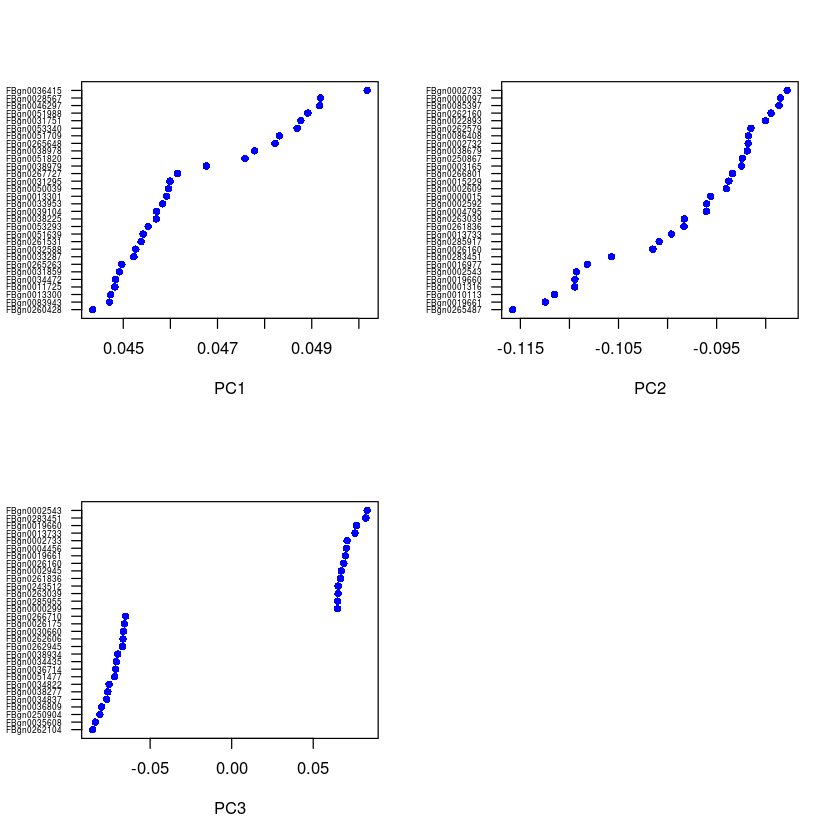

In [16]:
VizPCA(object = sobj, pcs.use = 1:3)

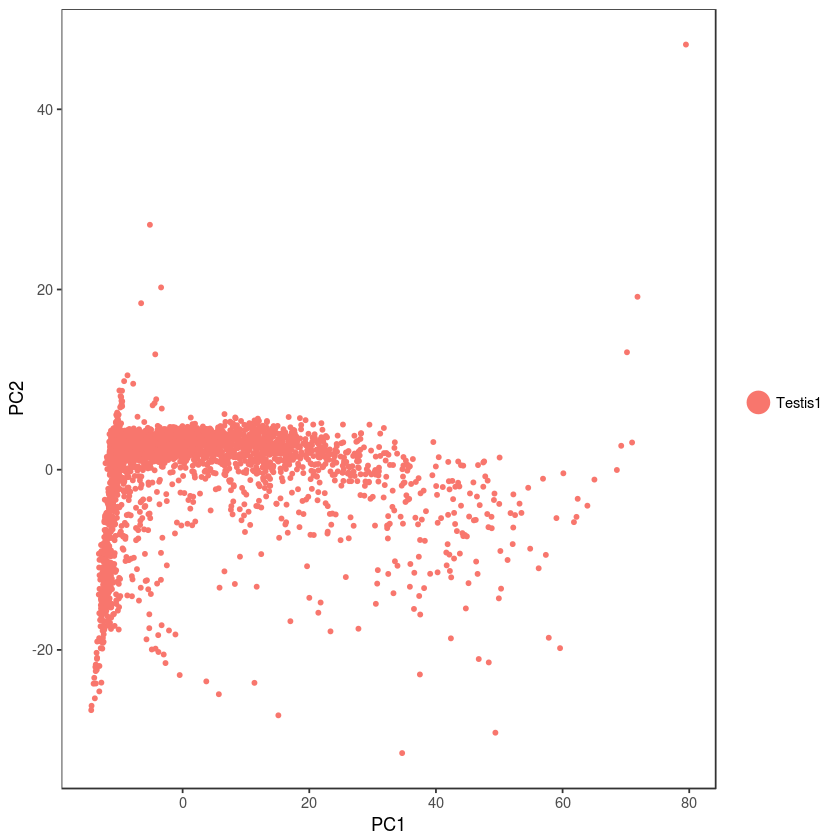

In [17]:
PCAPlot(object = sobj, dim.1 = 1, dim.2 = 2)

In [18]:
# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
sobj <- ProjectPCA(object = sobj, do.print = F)

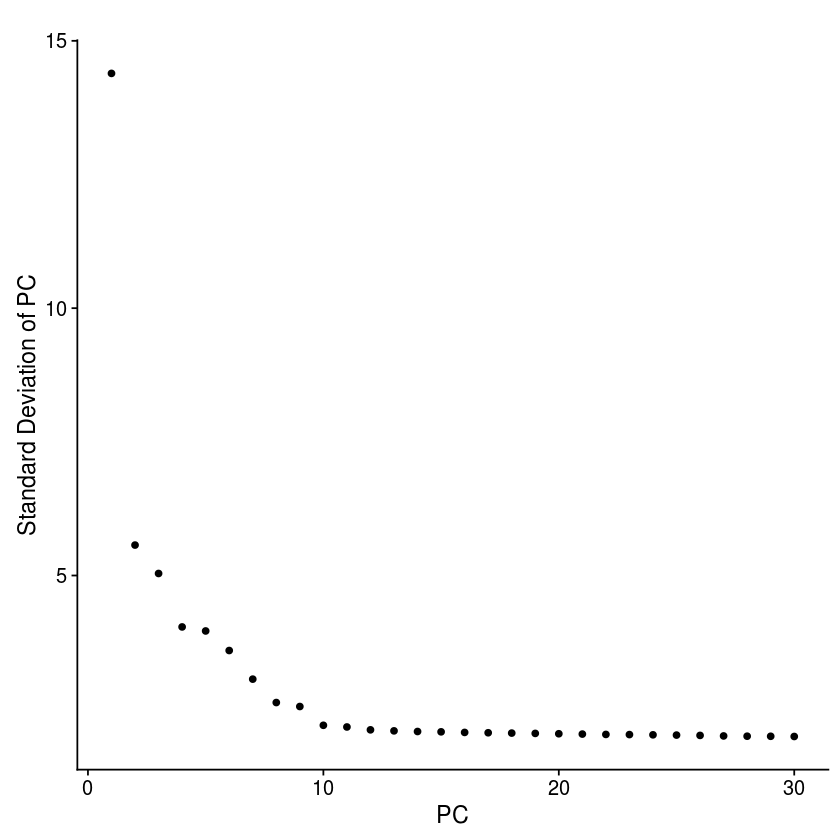

In [19]:
PCElbowPlot(object = sobj, num.pc=30)

In [20]:
sobj <- JackStraw(object = sobj, num.replicate = 100, do.print = FALSE, num.pc = 60)

Warning message:
“Removed 155734 rows containing missing values (geom_point).”

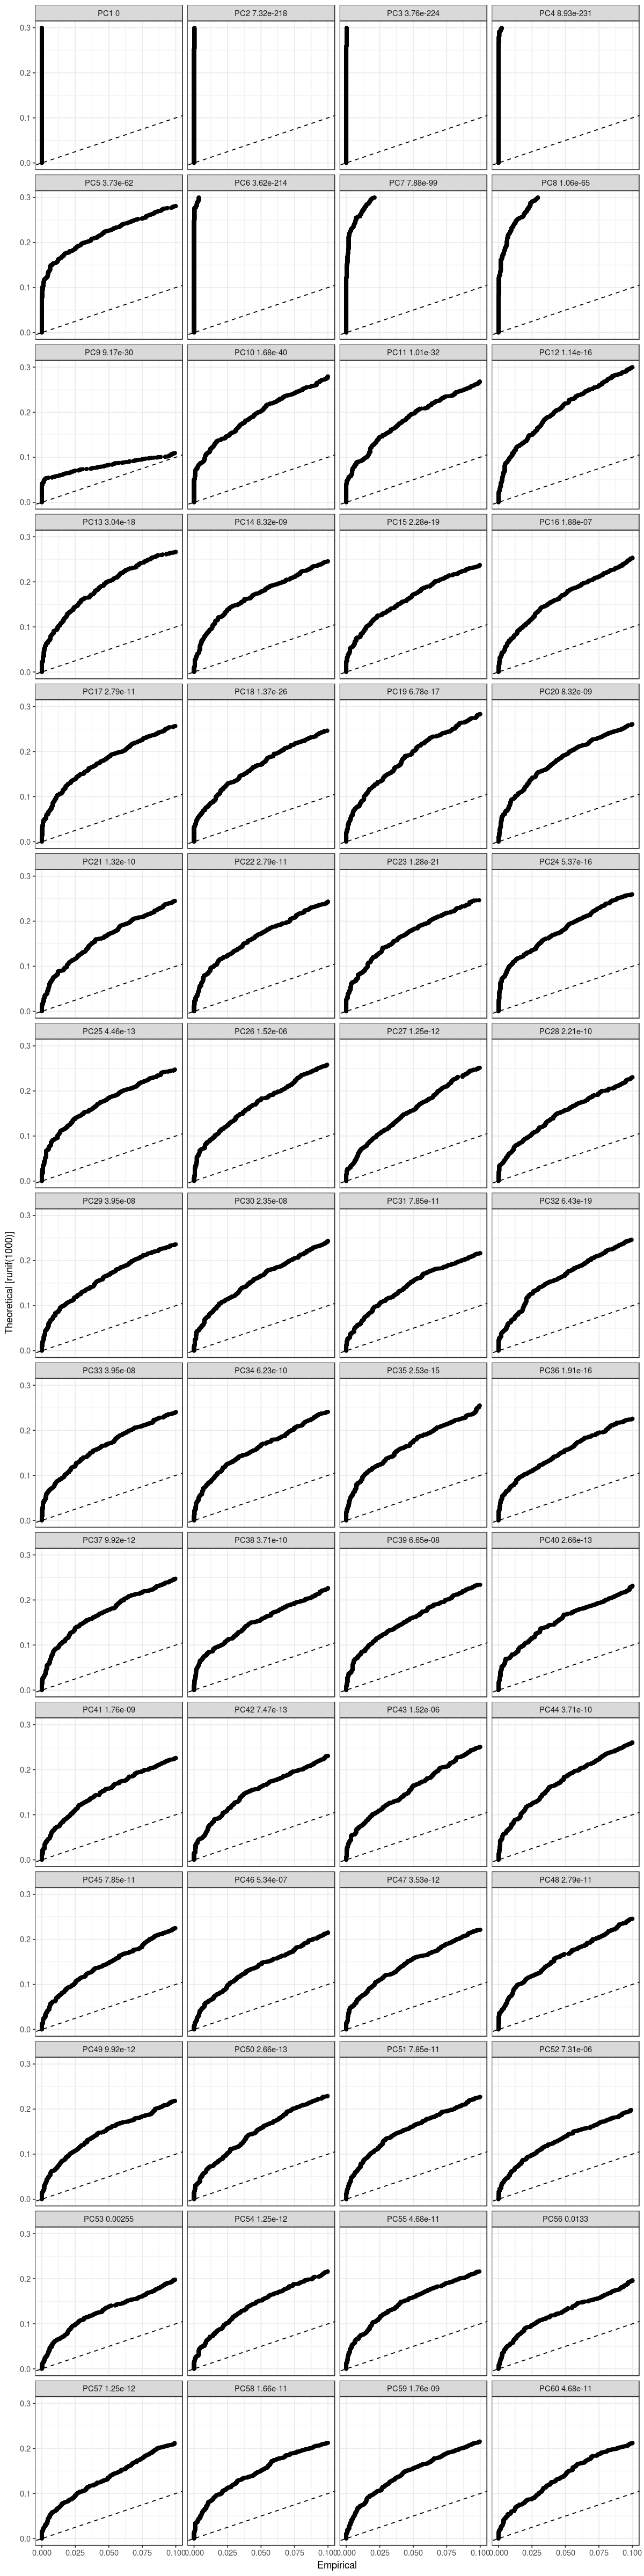

In [23]:
options(repr.plot.width=10, repr.plot.height=40)
JackStrawPlot(object = sobj, nCol = 4, PCs = 1:60)
options(repr.plot.width=10, repr.plot.height=10)

In [24]:
sobj <- FindClusters(
    object = sobj, 
    reduction.type = "pca", 
    dims.use = 1:48, 
    resolution = c(0.4, 0.6, 1.0, 1.2, 1.4),
    print.output = 0, 
    save.SNN = TRUE, 
)
PrintFindClustersParams(object = sobj)

Parameters used in latest FindClusters calculation run on: 2018-03-29 12:13:02
Resolution: 0.4
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48



In [25]:
### Run Non-linear dimensional reduction (tSNE)
sobj <- RunTSNE(object = sobj, dims.use = 1:48, do.fast = TRUE)

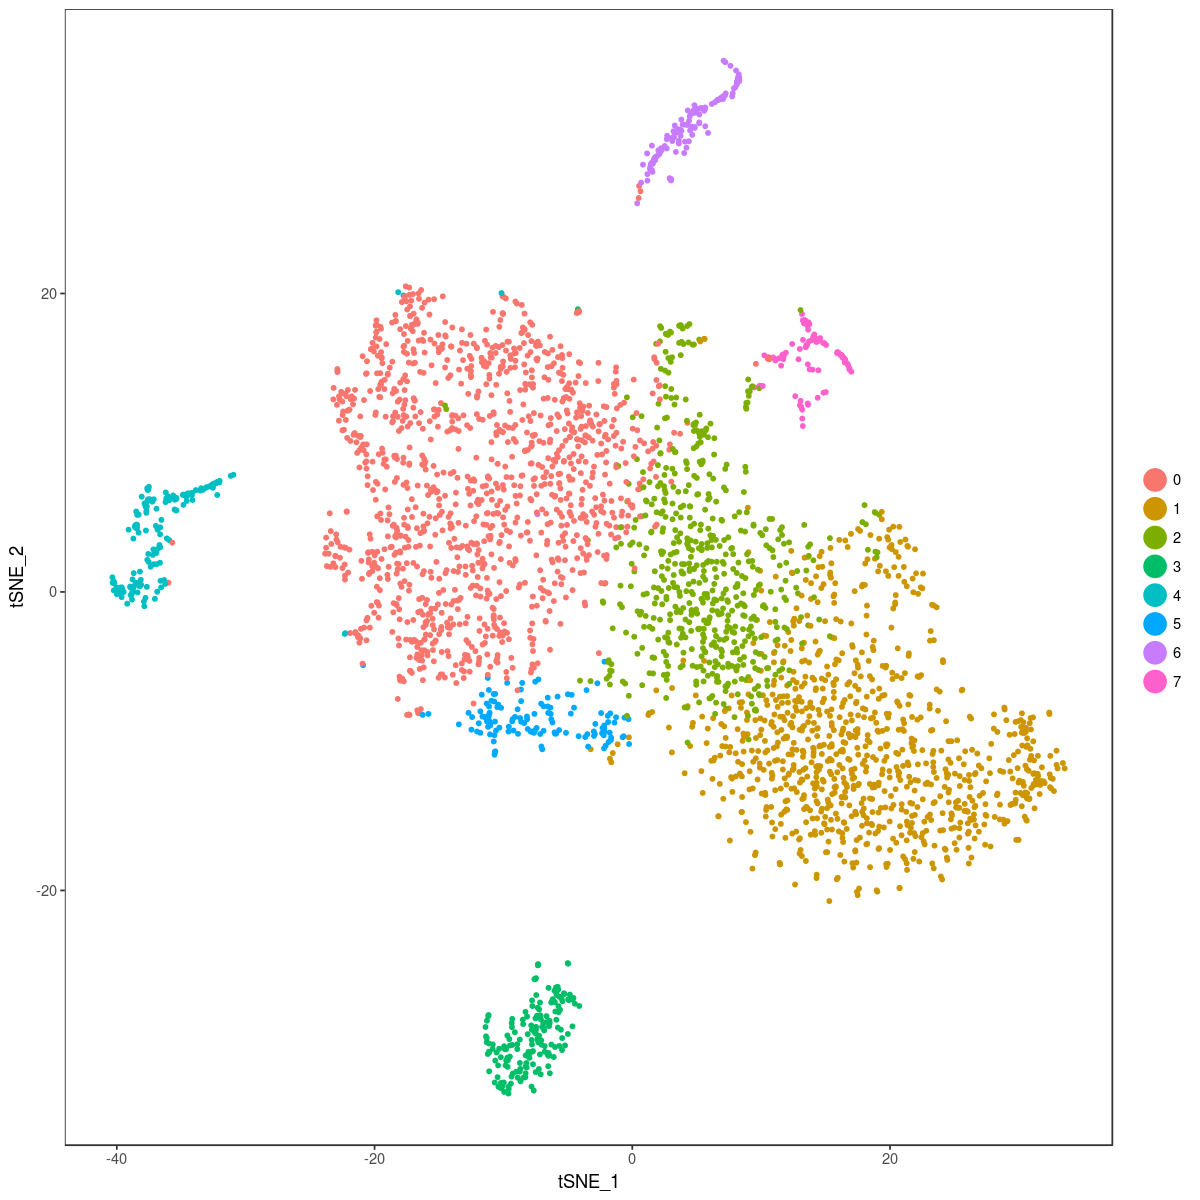

In [26]:
TSNEPlot(object = sobj, group.by='res.0.4')

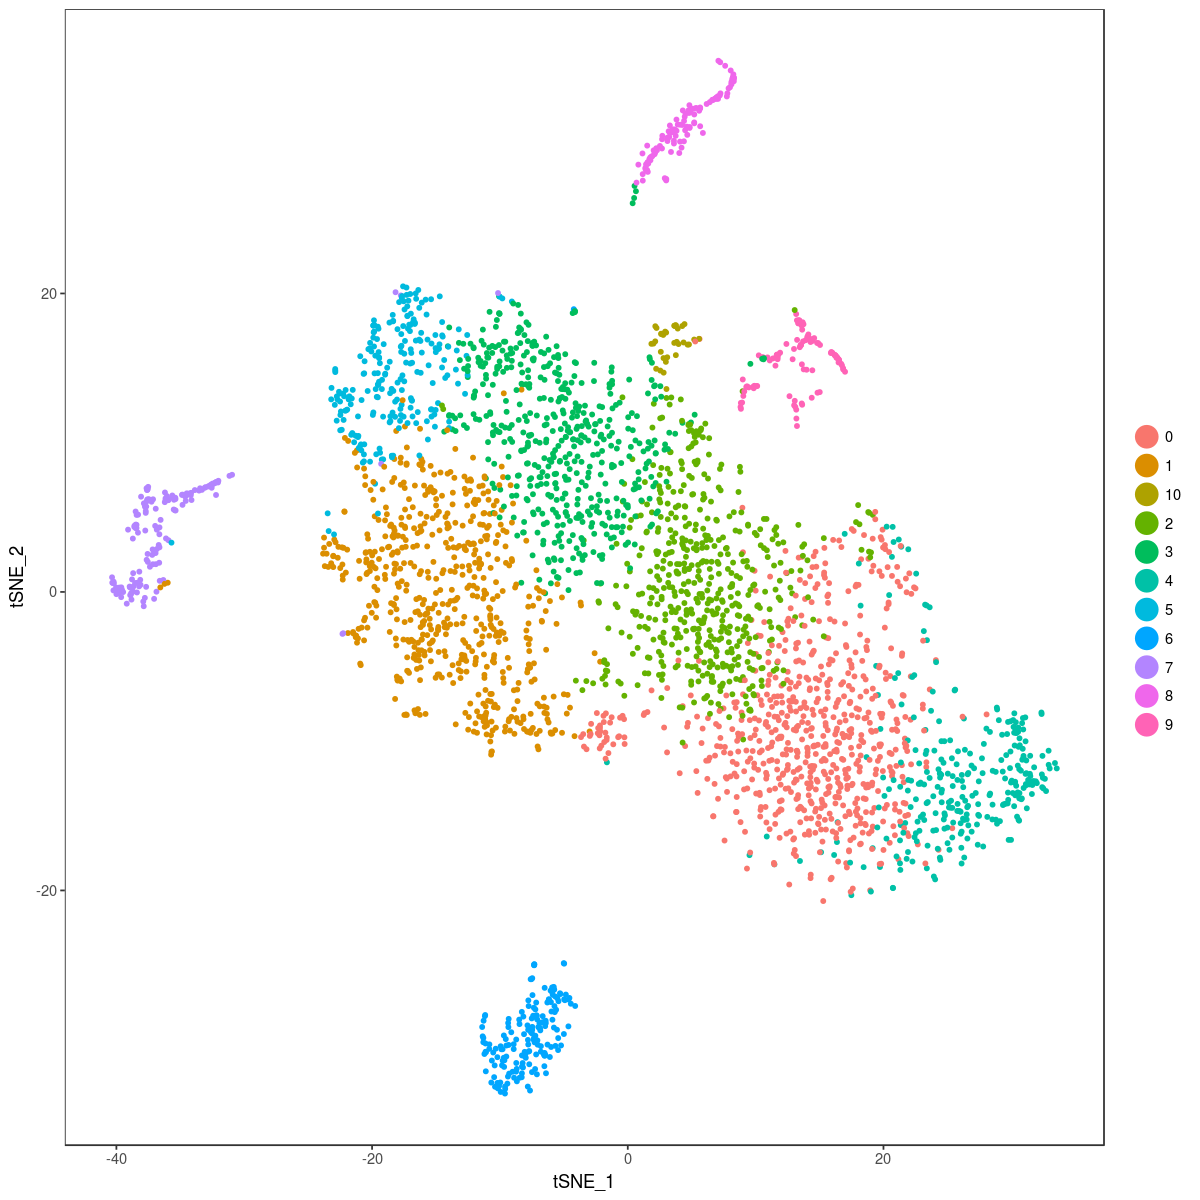

In [27]:
TSNEPlot(object = sobj, group.by='res.0.6')

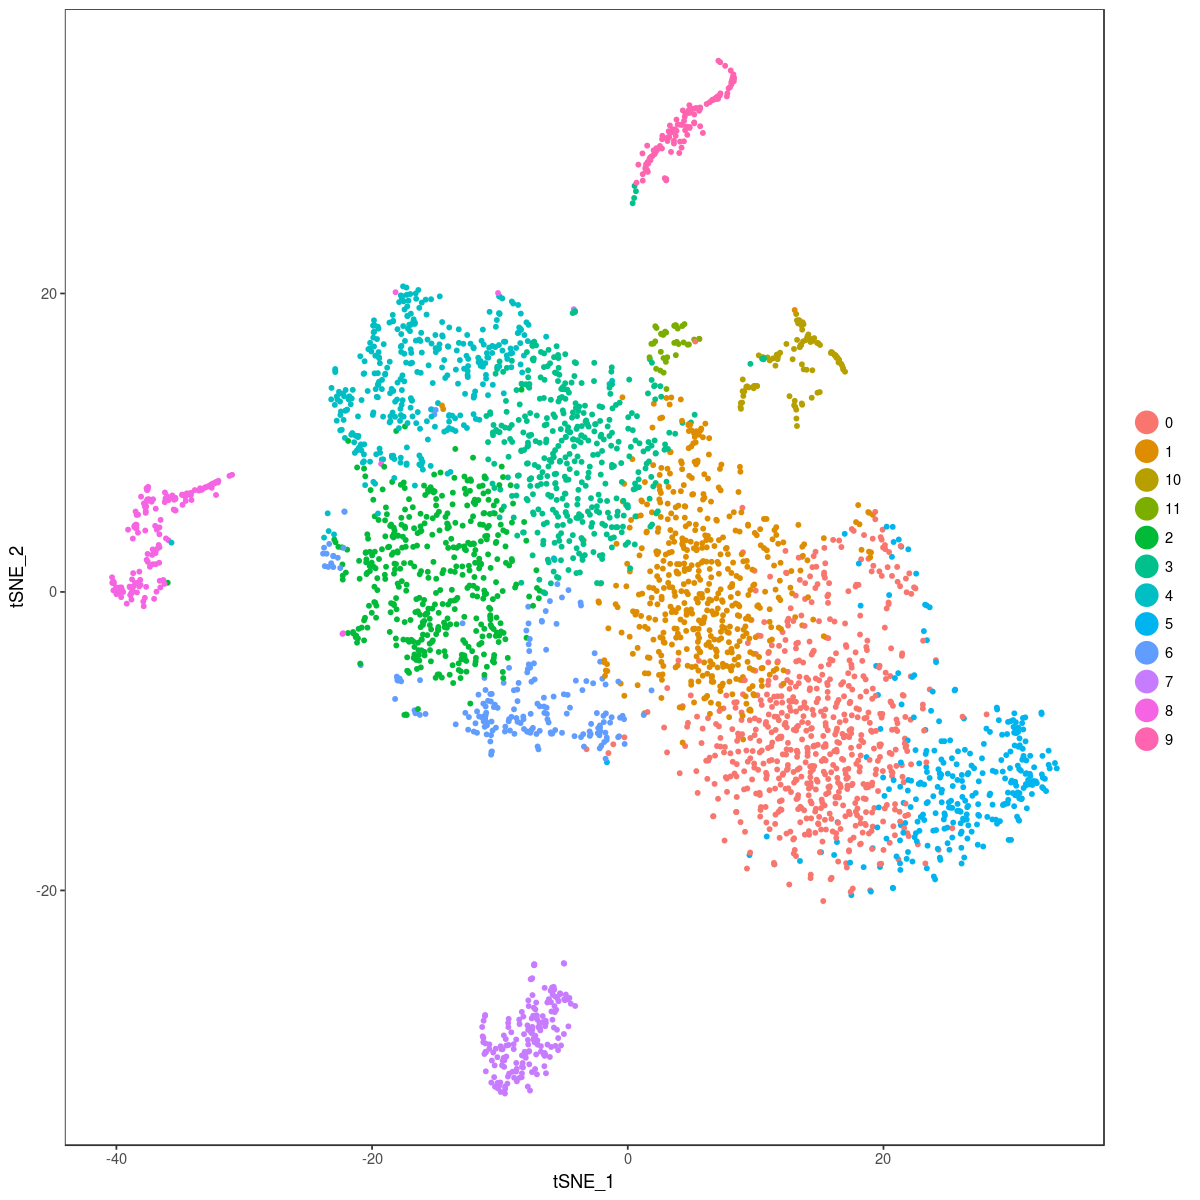

In [28]:
TSNEPlot(object = sobj, group.by='res.1')

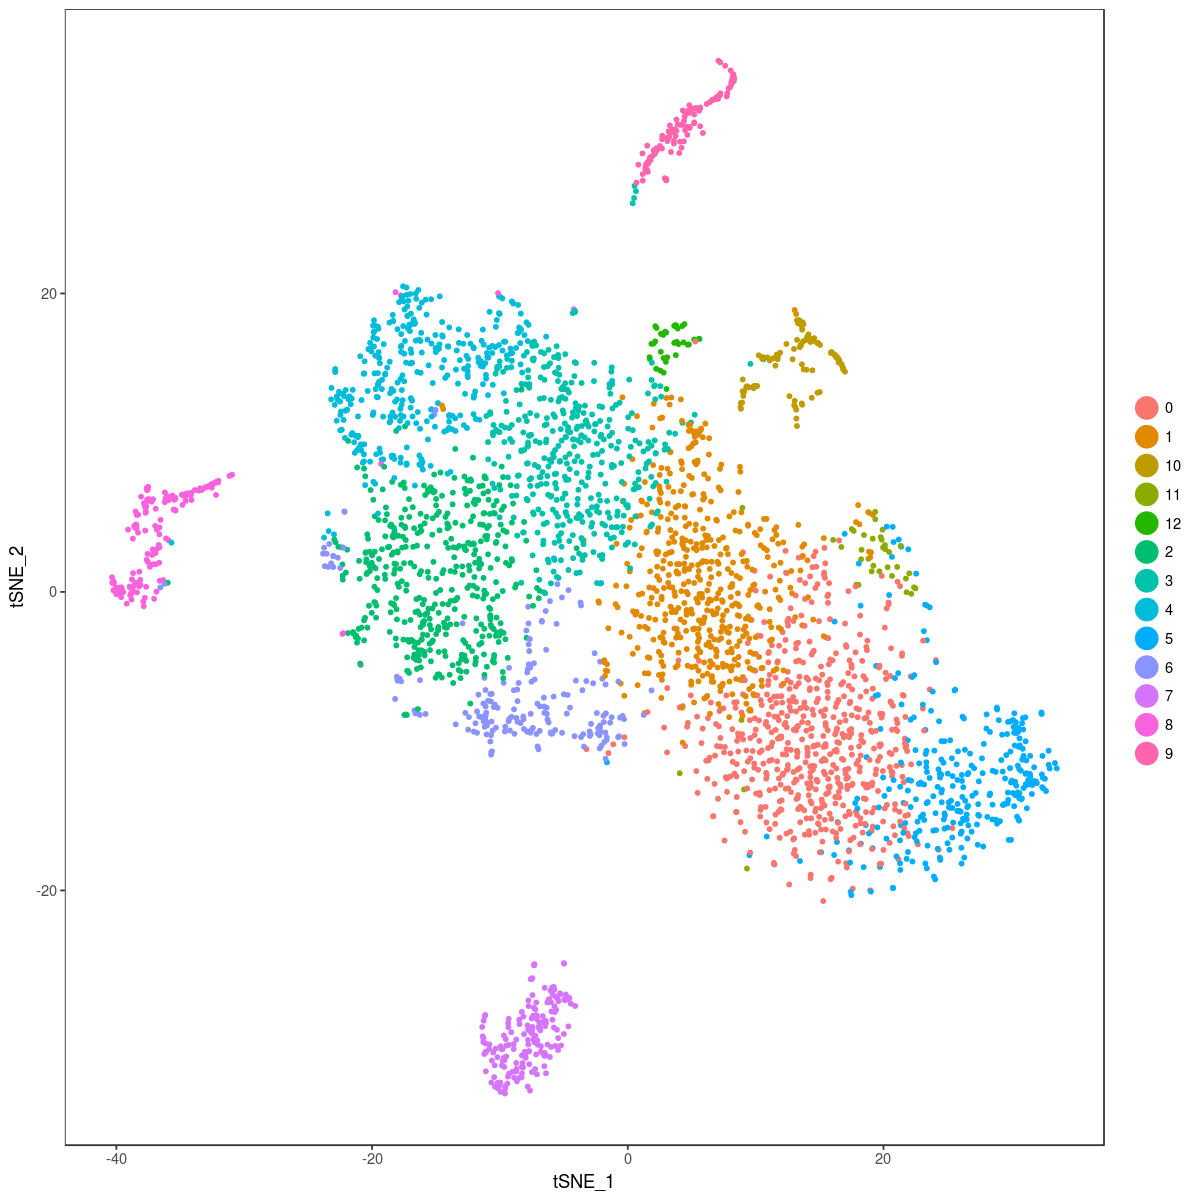

In [29]:
TSNEPlot(object = sobj, group.by='res.1.2')

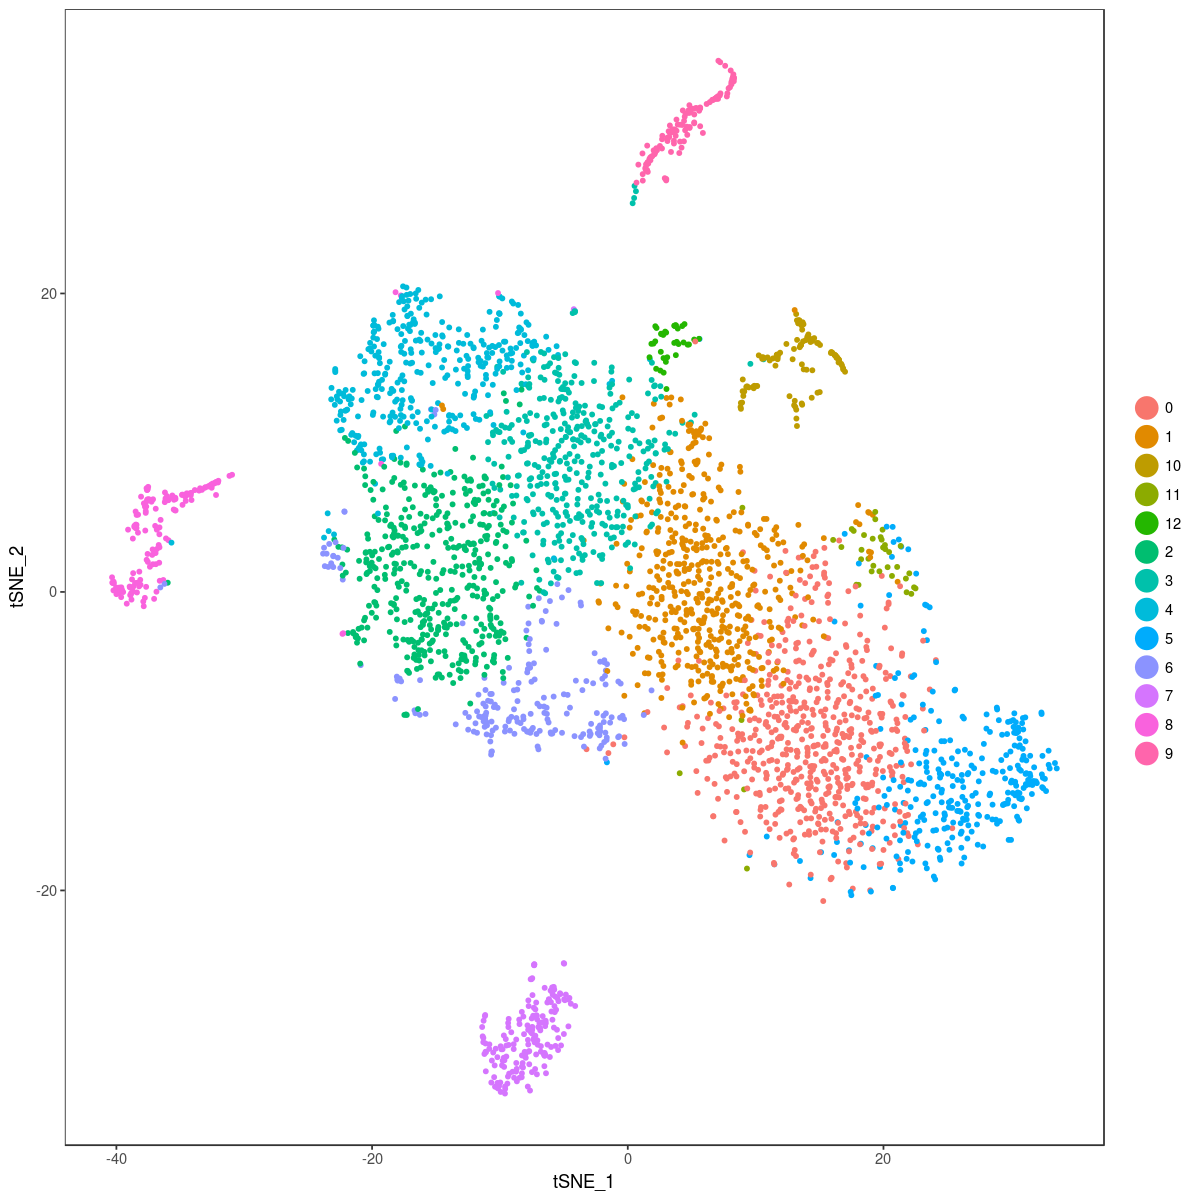

In [30]:
TSNEPlot(object = sobj, group.by='res.1.4')

In [31]:
dump_seurat(object = sobj, dir = OUTDIR)

In [32]:
# Save cluster info
params <- c(0.4, 0.6, 1.0, 1.2, 1.4)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    sobj <- SetAllIdent(sobj, id = name)
    markers <- FindAllMarkers(object = sobj, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR, fname = fname)
}